In [2]:
import pandas as pd
train_df = pd.read_csv('../usedataset/train.csv')
test_df = pd.read_csv('../usedataset/test.csv')
val_df = pd.read_csv('../usedataset/val.csv')

In [3]:
from tf_keras.preprocessing.text import Tokenizer
from tf_keras.preprocessing.sequence import pad_sequences

# 初始化 Tokenizer
tokenizer = Tokenizer(num_words=10000)  # 使用最频繁的 10000 个词
tokenizer.fit_on_texts(train_df['text'])

# 轉換文本到整數序列
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
val_sequences = tokenizer.texts_to_sequences(val_df['text'])
test_sequences = tokenizer.texts_to_sequences(test_df['text'])

# 統一序列長度
max_length = max(max(len(seq) for seq in train_sequences), 
                 max(len(seq) for seq in val_sequences), 
                 max(len(seq) for seq in test_sequences))
train_padded = pad_sequences(train_sequences, maxlen=max_length)
val_padded = pad_sequences(val_sequences, maxlen=max_length)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

In [4]:
import numpy as np
def load_glove_embeddings(path, word_index, embedding_dim=100):
    embeddings_index = {}
    with open(path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        # Look up the word embedding
        embedding_vector = embeddings_index.get(word)
        # If an embedding exists (i.e., the word is in the embedding index)
        if embedding_vector is not None:
            # If the embedding vector is less than 100 dimensions, pad it with zeros
            if len(embedding_vector) < 100:
                # Create a new vector with 0s of shape (100,)
                new_vector = np.zeros(100)
                # Assign the embedding to the beginning of this vector
                new_vector[:len(embedding_vector)] = embedding_vector
                # Assign this new vector to the embedding matrix
                embedding_matrix[i] = new_vector
            else:
                # If the embedding vector is already 100 dimensions, use it as is
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix = load_glove_embeddings('/Users/moonion/Documents/彰師大/02 私自學習/Machine Learning/Side Project/emotion-detection-lstm/glove.6B.100d.txt', tokenizer.word_index)
vocab_size = len(tokenizer.word_index)
print(embedding_matrix.shape)
print(embedding_matrix[1])

(15358, 100)
[-4.28950004e-02  7.06709981e-01  7.53160000e-01 -5.99629998e-01
 -8.01689982e-01  6.00939989e-01 -6.74189985e-01  2.35919997e-01
  2.40050003e-01 -3.63720000e-01 -2.27200001e-01  3.60260010e-02
  4.65909988e-01 -3.62329990e-01 -3.13250005e-01 -3.67570013e-01
 -5.72549999e-01  3.06609988e-01 -4.86059994e-01  6.32139981e-01
  2.89310008e-01  6.07410014e-01 -8.67880043e-03 -6.82060003e-01
 -1.84100002e-01  2.48469993e-01  9.59020033e-02 -6.91079974e-01
  9.08689976e-01 -3.92239988e-01  1.43450007e-01  7.81120002e-01
 -1.16010003e-01  6.03119992e-02  4.63000000e-01 -4.41909991e-02
  1.42839998e-01  6.22340024e-01  2.39429995e-01 -4.68149990e-01
 -2.25529999e-01 -3.19200009e-01  3.13970000e-01 -4.23079997e-01
 -4.08270001e-01 -2.46590003e-01  5.15720010e-01  3.54939997e-01
  3.15450013e-01 -1.40429997e+00 -1.64859995e-01 -5.55079989e-02
  1.02600001e-01  6.15149975e-01  1.26910001e-01 -2.23790002e+00
  6.95100009e-01  1.26090005e-01  1.09010005e+00  2.59530008e-01
  2.29739994

In [5]:
from sklearn.preprocessing import LabelEncoder
from tf_keras.utils import to_categorical

# Step 2: Preparing the labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['emotion'])
val_labels = label_encoder.transform(val_df['emotion'])
test_labels = label_encoder.transform(test_df['emotion'])

# Convert labels to categorical
train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)
test_labels = to_categorical(test_labels)

In [6]:
from tf_keras.models import Sequential
from tf_keras.layers import Embedding, LSTM, Dense, Dropout
from tf_keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

# 假設 embedding_matrix 已正确加載並具備正確的形狀：
# embedding_matrix.shape 應該是 (vocab_size, embedding_dim)

lstm_model = Sequential([
    Embedding(input_dim=vocab_size + 1,
              output_dim=100,  # 確保與 GloVe 向量的維度匹配
              weights=[embedding_matrix],  # 確保是一個列表
              input_length=max_length,
              trainable=False),  # 根據需要設置是否讓這些權重在訓練中更新
    LSTM(32),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(len(train_df['emotion'].unique()), activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 添加早停
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# 繼續模型訓練和評估
# Step 4: 訓練模型
history = lstm_model.fit(train_padded, train_labels, 
                    epochs=15, batch_size=64, validation_data=(val_padded, val_labels),
                    callbacks=[early_stopping])

# Step 5: 評估模型
test_loss, test_accuracy = lstm_model.evaluate(test_padded, test_labels)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test Loss: {:.2f}%".format(test_loss * 100))

# 輸出分類報告
y_pred_prob = lstm_model.predict(test_padded)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(test_labels, axis=1)
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", report)

2024-05-02 06:04:53.884054: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-05-02 06:04:53.884117: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-02 06:04:53.884128: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-02 06:04:53.884149: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-02 06:04:53.884169: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/15


2024-05-02 06:05:01.894122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 11s 14ms/step - loss: 1.4812 - accuracy: 0.4286 - val_loss: 1.2348 - val_accuracy: 0.5430
Epoch 2/15
250/250 [==============================] - 3s 13ms/step - loss: 1.1734 - accuracy: 0.5656 - val_loss: 0.9748 - val_accuracy: 0.6440
Epoch 3/15
250/250 [==============================] - 3s 13ms/step - loss: 0.9571 - accuracy: 0.6525 - val_loss: 0.7826 - val_accuracy: 0.7245
Epoch 4/15
250/250 [==============================] - 3s 13ms/step - loss: 0.8000 - accuracy: 0.7168 - val_loss: 0.6486 - val_accuracy: 0.7700
Epoch 5/15
250/250 [==============================] - 3s 13ms/step - loss: 0.6797 - accuracy: 0.7625 - val_loss: 0.5404 - val_accuracy: 0.8105
Epoch 6/15
250/250 [==============================] - 3s 13ms/step - loss: 0.5880 - accuracy: 0.7951 - val_loss: 0.4817 - val_accuracy: 0.8320
Epoch 7/15
250/250 [==============================] - 3s 12ms/step - loss: 0.5160 - accuracy: 0.8206 - val_loss: 0.4212 - val_accuracy: 0.8515
Epoch 8/1

In [8]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 100)           1535800   
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 6)                 102       
                                                                 
Total params: 1553454 (5.93 MB)
Trainable params: 17654 (68.96 KB)
Non-trainable params: 1535800 (5.86 MB)
_________________________________________________________________


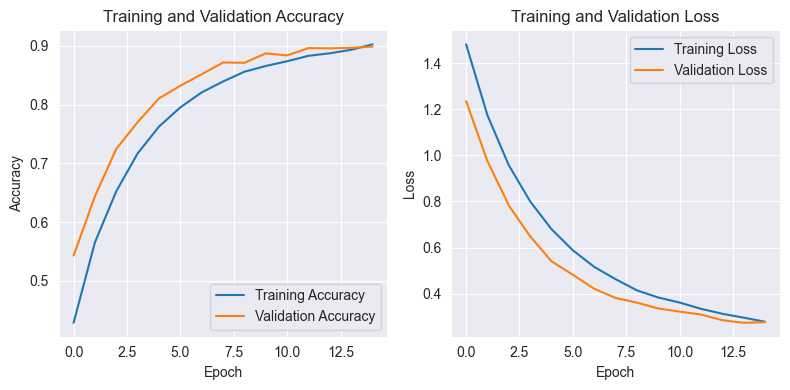

In [7]:
import matplotlib.pyplot as plt
# 繪製訓練和驗證的準確度
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 繪製訓練和驗證的損失
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()